In [2]:

#import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
plt.rcParams["figure.figsize"] = (20,10)

## Loading the datasets and merging the google searches with the prices data by date.

In [4]:
# Load the data and rename some columns for convenience
df = pd.read_csv("data/prices.csv")
google = pd.read_csv("data/GoogleData.csv")
google = google.rename(columns={'Unnamed: 0': 'Date',
                                'avocado: (United States)': 'avocado',
                                'organic: (United States)': 'organic', 
                                'avocado recipe: (United States)': 'recipe', 
                                'avocado toast: (United States)': 'toast', 
                                'avocado sandwich: (United States)': 'sandwich', 
                                'organic avocado: (United States)': 'organic_avocado'})
google.head()

,Date,avocado,organic,recipe,toast,sandwich,organic_avocado
0,2015-01-04,46,76,84,8,51,10
1,2015-01-11,48,79,76,8,38,29
2,2015-01-18,48,82,84,9,66,27
3,2015-01-25,49,82,89,8,44,28
4,2015-02-01,52,81,82,7,46,42


In [5]:
# These are the dates that are not common in the two datasets
notcommon = set(df['Date'].unique()).symmetric_difference(google['Date'].unique())

In [6]:
# These dates are in the google search but not in the price data, they will not be used
set(notcommon).intersection(google['Date'].unique())

{'2018-12-09',
 '2018-12-16',
 '2018-12-23',
 '2018-12-30',
 '2019-01-06',
 '2019-07-21',
 '2019-07-28'}

In [7]:
# This date is in the price data and not in google data, for this date the google search will have NA
set(notcommon).intersection(df['Date'].unique())

{'2019-01-07'}

In [8]:
# Left join google data with price data by date
df = pd.merge(df,google,on='Date',how='left')
df

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region,avocado,organic,recipe,toast,sandwich,organic_avocado
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany,46.0,76.0,84.0,8.0,51.0,10.0
1,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.00,conventional,2015,Atlanta,46.0,76.0,84.0,8.0,51.0,10.0
2,2015-01-04,NaN,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.00,conventional,2015,BaltimoreWashington,46.0,76.0,84.0,8.0,51.0,10.0
3,2015-01-04,1.01,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.00,conventional,2015,Boise,46.0,76.0,84.0,8.0,51.0,10.0
4,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.00,conventional,2015,Boston,46.0,76.0,84.0,8.0,51.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25156,2019-07-14,1.66,4007.93,218.47,252.29,0.00,3537.17,1460.65,2076.52,0.00,organic,2019,Syracuse,60.0,76.0,68.0,53.0,50.0,43.0
25157,2019-07-14,1.06,3767.89,129.01,0.00,0.00,3638.88,3635.55,3.33,0.00,organic,2019,Tampa,60.0,76.0,68.0,53.0,50.0,43.0
25158,2019-07-14,1.99,1236969.18,106370.49,209820.63,5606.10,915082.38,667494.94,247562.25,25.19,organic,2019,TotalUS,60.0,76.0,68.0,53.0,50.0,43.0
25159,2019-07-14,2.33,209408.22,23918.57,42432.02,985.67,142071.96,75883.13,66163.64,25.19,organic,2019,West,60.0,76.0,68.0,53.0,50.0,43.0


## Data exploration

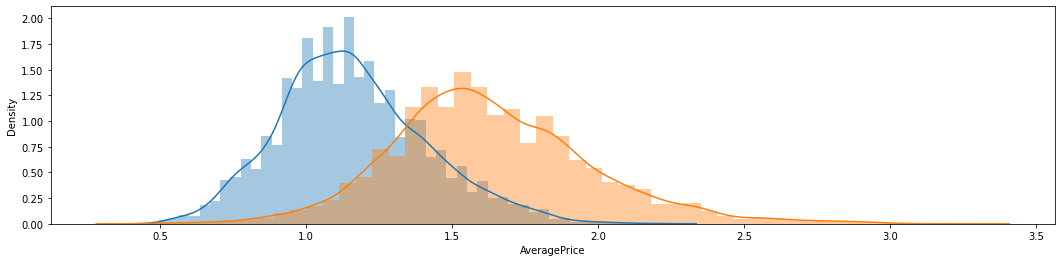

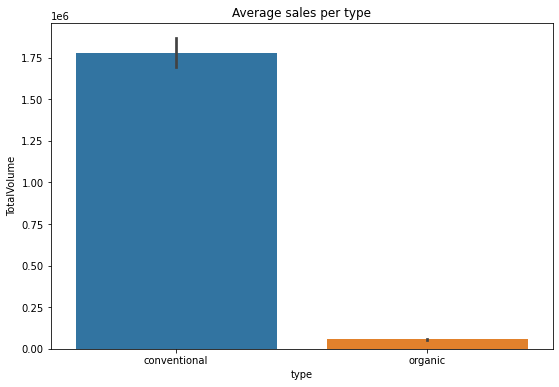

In [120]:
# Organic is more expensive than conventional
df_conventional = df[df['type'] == 'conventional']
# df_conventional.shape
df_organic = df[df['type'] == 'organic']
# df_organic.shape
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
sns.distplot(df_conventional['AveragePrice']) # histogram
sns.distplot(df_organic['AveragePrice']) # histogram
plt.show()

# Sales are much lower for organic
plt.figure(figsize = (9,6))
plt.title('Average sales per type')
sns.barplot(x = 'type', y= 'TotalVolume', data = df)

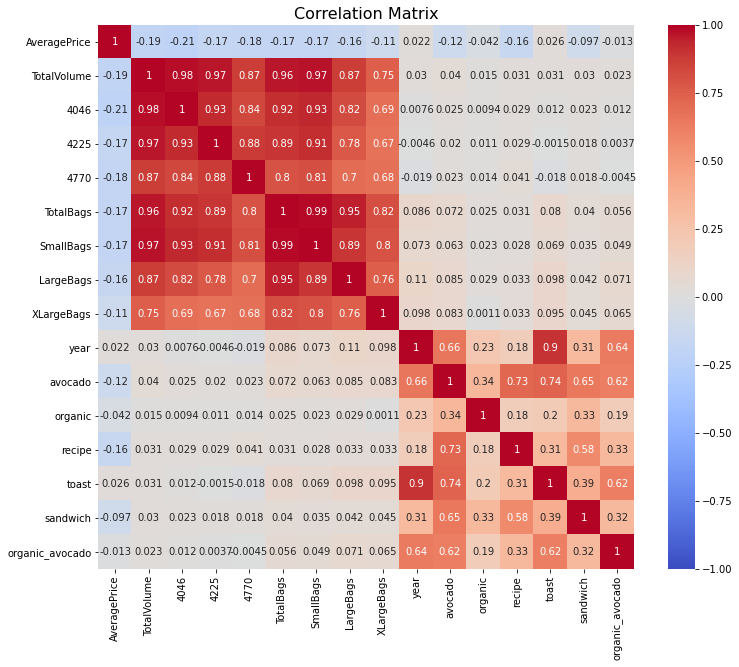

In [121]:
# Variable correlations
corrmat = df.corr()
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
filter = df.columns != 'id'
sns.heatmap(df[df.columns[filter]].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

In [122]:
dates = [datetime.datetime.strptime(ts, "%Y-%m-%d") for ts in df['Date']]
dates.sort()
sorteddates = [datetime.datetime.strftime(ts, "%Y-%m-%d") for ts in dates]
df['Date'] = pd.DataFrame({'Date':sorteddates})
year, df['Month'],  df['Day'] = df['Date'].str.split('-').str

season = {1: 'winter', 4: 'autumn', 3: 'summer', 2: 'spring'}
df['season'] = [(month%12 + 3)//3 for month in df['Month'].astype(int)]
df.season = [season[i] for i in df.season]

df.season

0        winter
1        winter
2        winter
3        winter
4        winter
          ...  
25156    summer
25157    summer
25158    summer
25159    summer
25160    summer
Name: season, Length: 25161, dtype: object

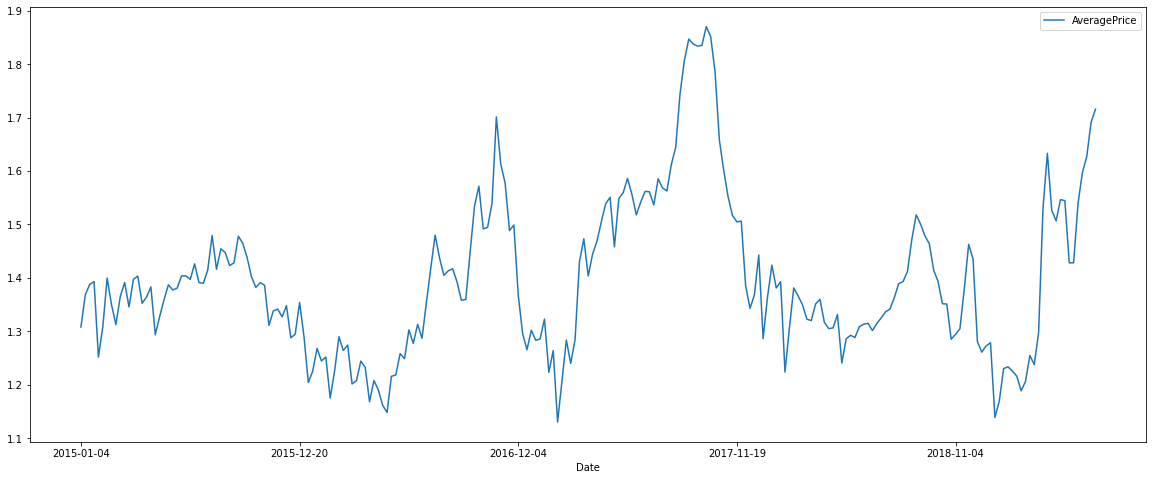

In [123]:
dategroup=df.groupby('Date').mean()
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
dategroup.plot(y='AveragePrice', ax=ax)

Text(0.5, 1.0, 'Avocado searches')

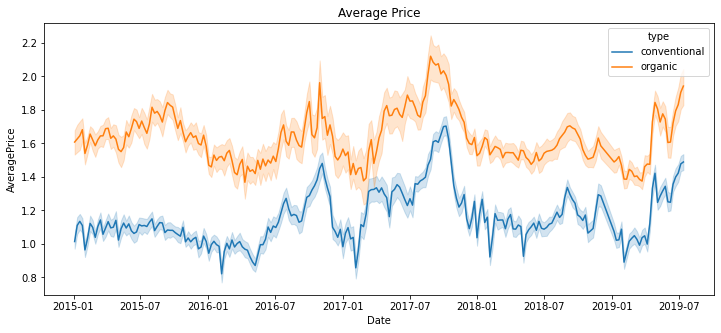

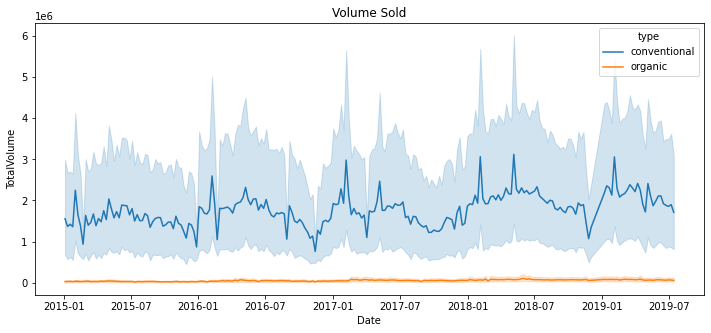

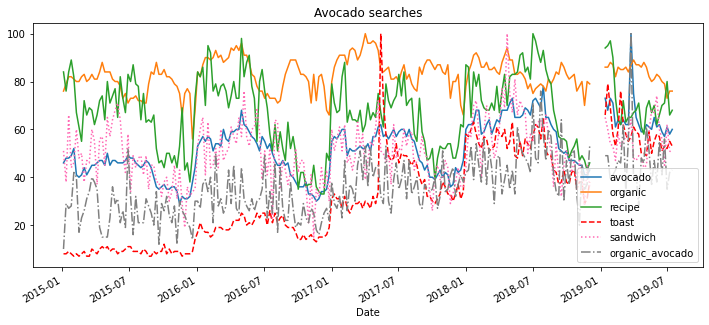

In [124]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

# plot average time trends by date
plt.figure(figsize=(12,5))
sns.lineplot(x = 'Date', y = 'AveragePrice' , data = df, hue = 'type')
plt.title('Average Price')

plt.figure(figsize=(12,5))
sns.lineplot(x = 'Date', y = 'TotalVolume' , data = df, hue = 'type')
plt.title('Volume Sold')

dategroup=df.groupby('Date').mean()

plt.figure(figsize=(12,5))
dategroup['avocado'].plot(x=df.Date)
dategroup['organic'].plot(x=df.Date)
dategroup['recipe'].plot(x=df.Date)
dategroup['toast'].plot(x=df.Date, linestyle='dashed', color='r')
dategroup['sandwich'].plot(x=df.Date, linestyle='dotted', color='hotpink')
dategroup['organic_avocado'].plot(x=df.Date, linestyle='dashdot', color='grey')

plt.legend(labels=["avocado","organic","recipe",'toast', 'sandwich', 'organic_avocado'])
plt.title('Avocado searches')


Text(0.5, 1.0, 'avocado searches vs volume sold')

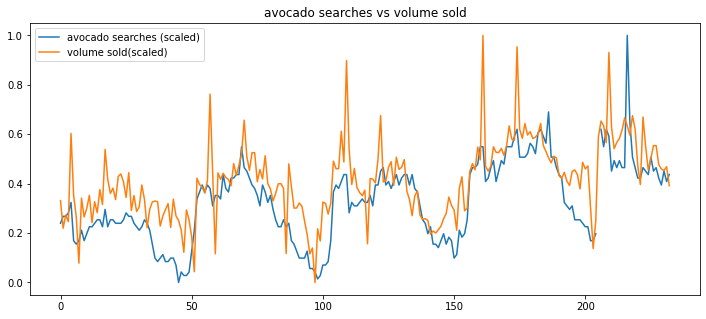

In [125]:
scaler = MinMaxScaler()
scaler.fit(dategroup[['avocado','TotalVolume']])
plotdata = pd.DataFrame(scaler.transform(dategroup[['avocado','TotalVolume']]))

plt.figure(figsize=(12,5))
plotdata[0].plot(x=df.Date)
plotdata[1].plot(x=df.Date)
plt.legend(labels=["avocado searches (scaled)","volume sold(scaled)"])
plt.title('avocado searches vs volume sold')

Text(0.5, 1.0, 'Avocado searches by month')

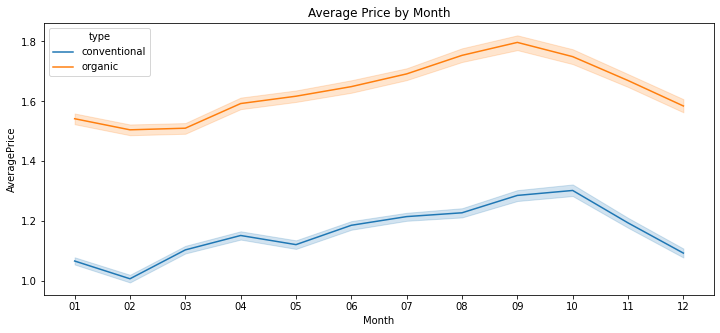

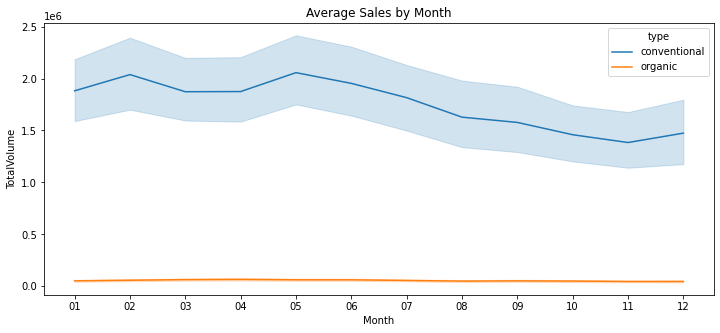

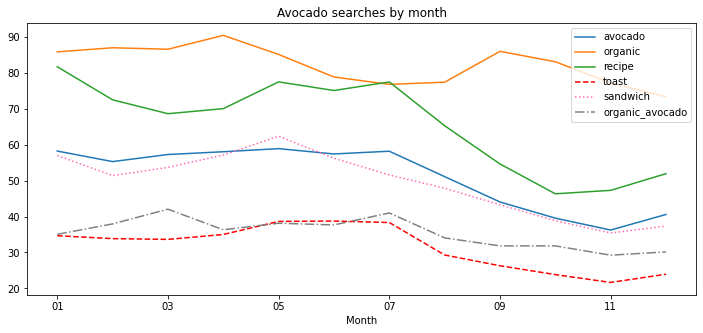

In [126]:
fig, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set(ticks=range(0,13)) # Manually set x-ticks
sns.lineplot(x = 'Month', y = 'AveragePrice' , data = df, hue = 'type')
plt.title('Average Price by Month')

fig, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set(ticks=range(0,13)) # Manually set x-ticks
sns.lineplot(x = 'Month', y = 'TotalVolume' , data = df, hue = 'type')
plt.title('Average Sales by Month')

monthgroup=df.groupby('Month').mean()
plt.figure(figsize=(12,5))
monthgroup['avocado'].plot(x=df.Date)
monthgroup['organic'].plot(x=df.Date)
monthgroup['recipe'].plot(x=df.Date)
monthgroup['toast'].plot(x=df.Date, linestyle='dashed', color='r')
monthgroup['sandwich'].plot(x=df.Date, linestyle='dotted', color='hotpink')
monthgroup['organic_avocado'].plot(x=df.Date, linestyle='dashdot', color='grey')

plt.legend(labels=["avocado","organic","recipe",'toast', 'sandwich', 'organic_avocado'])
plt.title('Avocado searches by month')

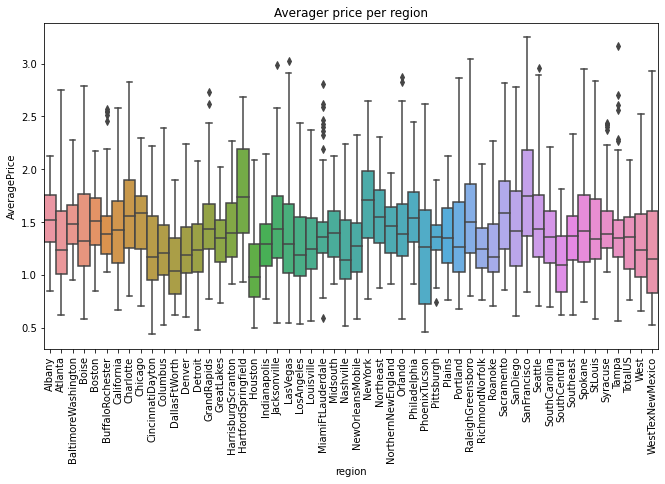

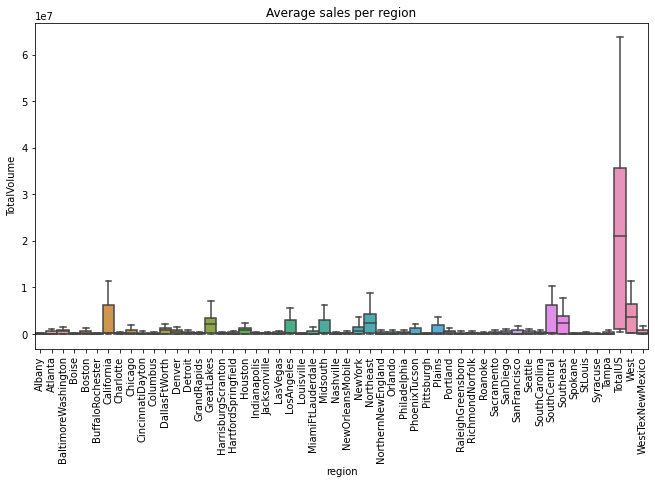

In [127]:
plt.figure(figsize =(11,6))
plt.title('Averager price per region')
plt.xticks(rotation ='vertical')
sns.boxplot(x = 'region', y = 'AveragePrice', data = df, width = 1, whis= 2)

plt.figure(figsize =(11,6))
plt.title('Average sales per region')
plt.xticks(rotation ='vertical')
sns.boxplot(x = 'region', y = 'TotalVolume', data = df, width = 1, whis= 2)

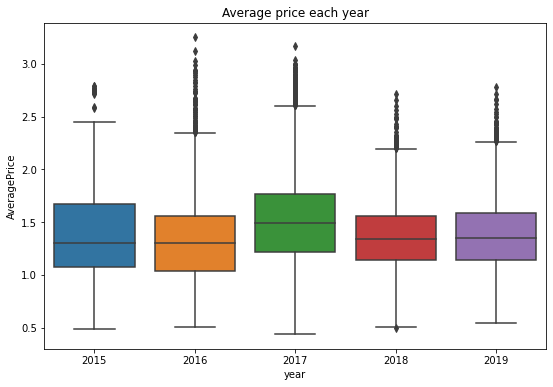

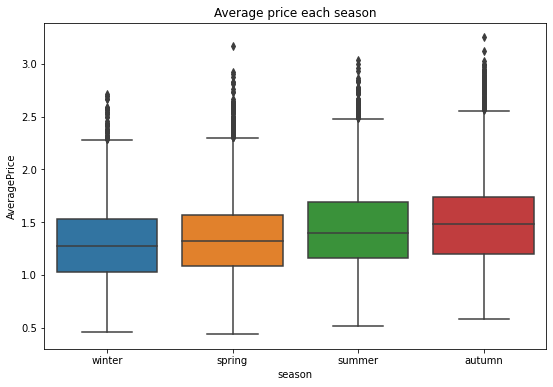

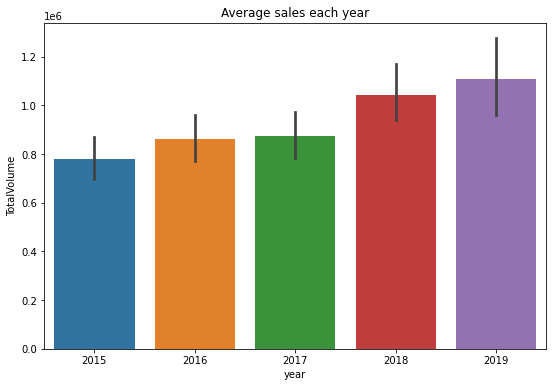

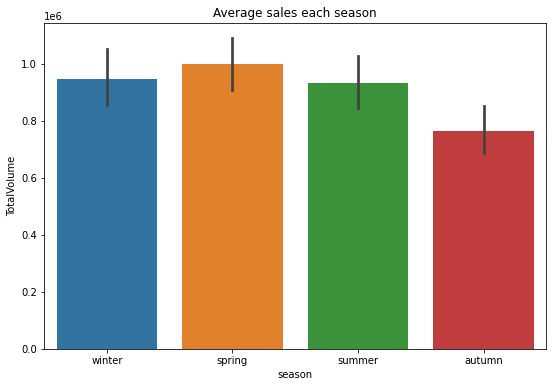

In [128]:
plt.figure(figsize = (9,6))
plt.title('Average price each year')
sns.boxplot(x = 'year', y= 'AveragePrice', data = df)

plt.figure(figsize = (9,6))
plt.title('Average price each season')
sns.boxplot(x = 'season', y= 'AveragePrice', data = df)

plt.figure(figsize = (9,6))
plt.title('Average sales each year')
sns.barplot(x = 'year', y= 'TotalVolume', data = df)

plt.figure(figsize = (9,6))
plt.title('Average sales each season')
sns.barplot(x = 'season', y= 'TotalVolume', data = df)

## Forecasting price with FB prophet for total US


In [ ]:

#each region has 466 entries
regions = df.groupby(df.region)
print("Total regions :", len(regions))
print("-------------")
for name, group in regions:
    print(name, " : ", len(group))

Total regions : 54
-------------
Albany  :  466
Atlanta  :  466
BaltimoreWashington  :  466
Boise  :  466
Boston  :  466
BuffaloRochester  :  466
California  :  466
Charlotte  :  466
Chicago  :  466
CincinnatiDayton  :  466
Columbus  :  466
DallasFtWorth  :  466
Denver  :  466
Detroit  :  466
GrandRapids  :  466
GreatLakes  :  466
HarrisburgScranton  :  466
HartfordSpringfield  :  466
Houston  :  466
Indianapolis  :  466
Jacksonville  :  466
LasVegas  :  466
LosAngeles  :  466
Louisville  :  466
MiamiFtLauderdale  :  466
Midsouth  :  466
Nashville  :  466
NewOrleansMobile  :  466
NewYork  :  466
Northeast  :  466
NorthernNewEngland  :  466
Orlando  :  466
Philadelphia  :  466
PhoenixTucson  :  466
Pittsburgh  :  466
Plains  :  466
Portland  :  466
RaleighGreensboro  :  466
RichmondNorfolk  :  466
Roanoke  :  466
Sacramento  :  466
SanDiego  :  466
SanFrancisco  :  466
Seattle  :  466
SouthCarolina  :  466
SouthCentral  :  466
Southeast  :  466
Spokane  :  466
StLouis  :  466
Syracuse  

In [ ]:
# Renaming the columns for the prophet before temporal split
renamed = regions.get_group('TotalUS')[['Date', 'AveragePrice']].reset_index(drop=True)
renamed = renamed.rename(columns={"Date": "ds", "AveragePrice": "y"})
# Making a train set with data before 2018, holdout a test set with data after 2018
train_set = renamed.loc[lambda df: df['ds'].dt.year < 2018, :][['ds', 'y']]
test_set = renamed.loc[lambda df: df['ds'].dt.year >= 2018, :][['ds', 'y']]

print(train_set.shape, test_set.shape)

(314, 2) (152, 2)


In [ ]:
from fbprophet import Prophet 
from fbprophet.plot import add_changepoints_to_plot

proph = Prophet(yearly_seasonality=True, \
            daily_seasonality=False, weekly_seasonality=False) 
proph.fit(train_set)
future = proph.make_future_dataframe(periods=19,freq='MS')
forecast = proph.predict(future)

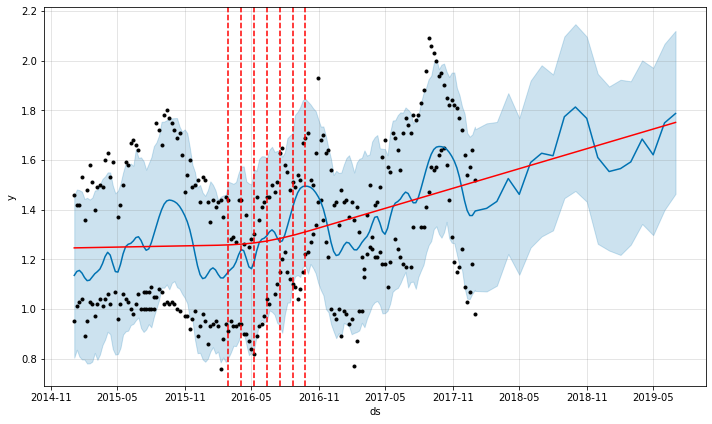

In [ ]:
fig = proph.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), proph, forecast)

Visualize the real average prices vs the forecast

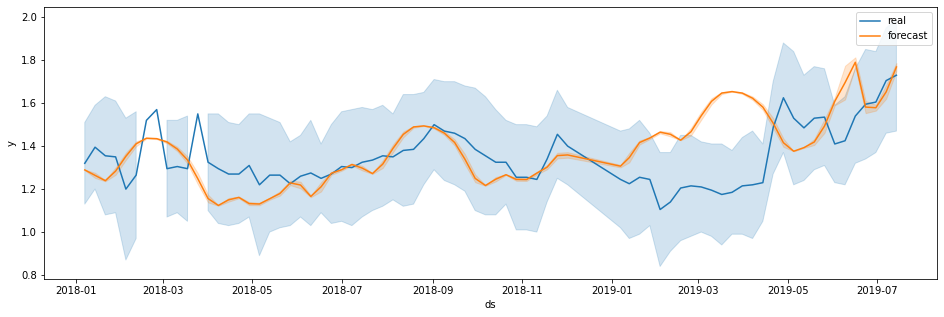

In [ ]:
prophet_pred = pd.DataFrame({"Date" : forecast[-test_set.shape[0]:]['ds'],
                             "Pred" : forecast[-test_set.shape[0]:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
#prophet_pred.index.freq = "MS"
test_set["Prophet_Predictions"] = prophet_pred['Pred'].values
test_set = test_set.set_index("ds")

plt.figure(figsize=(16,5))
sns.lineplot(x= test_set.index, y=test_set["y"])
sns.lineplot(x=test_set.index, y = test_set["Prophet_Predictions"])
plt.legend(labels=["real","forecast"])


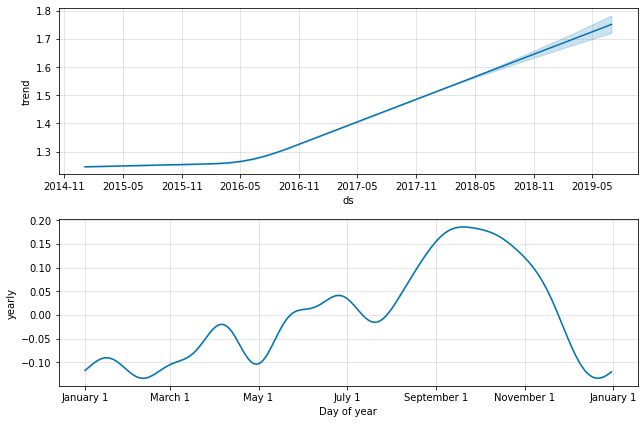

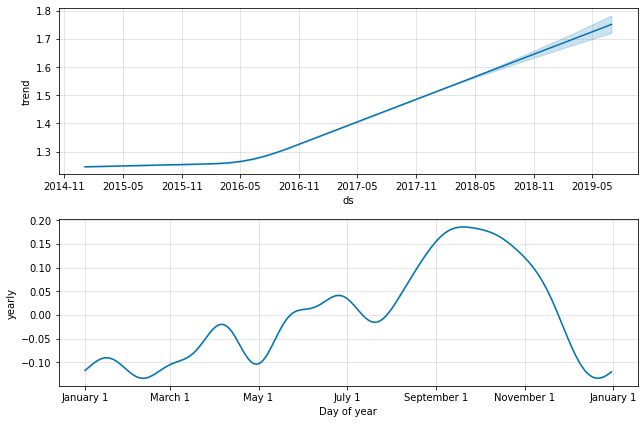

In [ ]:
# components(trend and seasonality)
proph.plot_components(forecast)

#Predict sales using google search data and prices from a week prior

In [129]:
# Create response variable ShiftedSales, that is the total volume for the future week
df['ShiftedSales'] = df.groupby(['region', 'type'])['TotalVolume'].shift(-1)
df.head()

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region,avocado,organic,recipe,toast,sandwich,organic_avocado,Month,Day,season,ShiftedSales
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,46.0,76.0,84.0,8.0,51.0,10.0,01,04,winter,41195.08
1,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta,46.0,76.0,84.0,8.0,51.0,10.0,01,04,winter,397542.72
2,2015-01-04,NaN,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington,46.0,76.0,84.0,8.0,51.0,10.0,01,04,winter,670231.94
3,2015-01-04,1.01,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.0,conventional,2015,Boise,46.0,76.0,84.0,8.0,51.0,10.0,01,04,winter,57355.52
4,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston,46.0,76.0,84.0,8.0,51.0,10.0,01,04,winter,437771.89


In [130]:
check = df[df.region == "TotalUS"]
check[['Date','region', 'type', 'TotalVolume', 'ShiftedSales']]

,Date,region,type,TotalVolume,ShiftedSales
51,2015-01-04,TotalUS,conventional,31324277.73,29063542.75
105,2015-01-04,TotalUS,organic,612910.15,669528.88
159,2015-01-11,TotalUS,conventional,29063542.75,29043458.85
213,2015-01-11,TotalUS,organic,669528.88,713120.00
267,2015-01-18,TotalUS,conventional,29043458.85,28470310.84
...,...,...,...,...,...
24942,2019-06-30,TotalUS,organic,1483274.36,1392880.01
24996,2019-07-07,TotalUS,conventional,38883159.64,34945476.94
25050,2019-07-07,TotalUS,organic,1392880.01,1236969.18
25104,2019-07-14,TotalUS,conventional,34945476.94,NaN


In [131]:
# Remove NA
df = df.dropna()

#encode variable
df['type']= df['type'].map({'conventional':0,'organic':1})

# Creating dummy variables
dummies = pd.get_dummies(df[['year','region', 'Month', 'season']],drop_first=True)
df_dummies = pd.concat([df[['AveragePrice',"type", 'avocado', 'organic', 
                            'recipe', 'toast', 'sandwich', 'organic_avocado']],dummies],axis=1)
target = df['ShiftedSales']

#sales in million units
target = target/1000000


In [187]:

# Splitting data into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_dummies,target,test_size=0.20,
                                                    random_state=42)

# Standardizing the data
cols_to_std = ['AveragePrice', 'avocado', 'organic', 'recipe', 'toast', 'sandwich',
               'organic_avocado']
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train[cols_to_std])
X_train[cols_to_std] = scaler.transform(X_train[cols_to_std])
X_test[cols_to_std] = scaler.transform(X_test[cols_to_std])

In [188]:
print(X_train.shape, X_test.shape, X_train.columns)

(14077, 76) (3520, 76) Index(['AveragePrice', 'type', 'avocado', 'organic', 'recipe', 'toast',
       'sandwich', 'organic_avocado', 'year', 'region_Atlanta',
       'region_BaltimoreWashington', 'region_Boise', 'region_Boston',
       'region_BuffaloRochester', 'region_California', 'region_Charlotte',
       'region_Chicago', 'region_CincinnatiDayton', 'region_Columbus',
       'region_DallasFtWorth', 'region_Denver', 'region_Detroit',
       'region_GrandRapids', 'region_GreatLakes', 'region_HarrisburgScranton',
       'region_HartfordSpringfield', 'region_Houston', 'region_Indianapolis',
       'region_Jacksonville', 'region_LasVegas', 'region_LosAngeles',
       'region_Louisville', 'region_MiamiFtLauderdale', 'region_Midsouth',
       'region_Nashville', 'region_NewOrleansMobile', 'region_NewYork',
       'region_Northeast', 'region_NorthernNewEngland', 'region_Orlando',
       'region_Philadelphia', 'region_PhoenixTucson', 'region_Pittsburgh',
       'region_Plains', 'region_Port

In [189]:
# cv params
NFOLD = 5
SEED = 123
METRIC = 'neg_mean_squared_error'

LinearRegression: -7.116296397098063 (0.6893231947919501)
KNN: -12.862348233749525 (2.2458892986658205)
DT: -0.5526544910664434 (0.14580389622660386)
MLP: -8.080410473384603 (1.0041733494259448)
RF: -0.29027870236120973 (0.13696624328875806)
AdaBoost: -2.1240977396976914 (0.10661216995965624)
GBR: -0.39673871524160986 (0.15038948543746522)
[09:50:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:50:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:50:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:50:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:50:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: -0.391785994411057

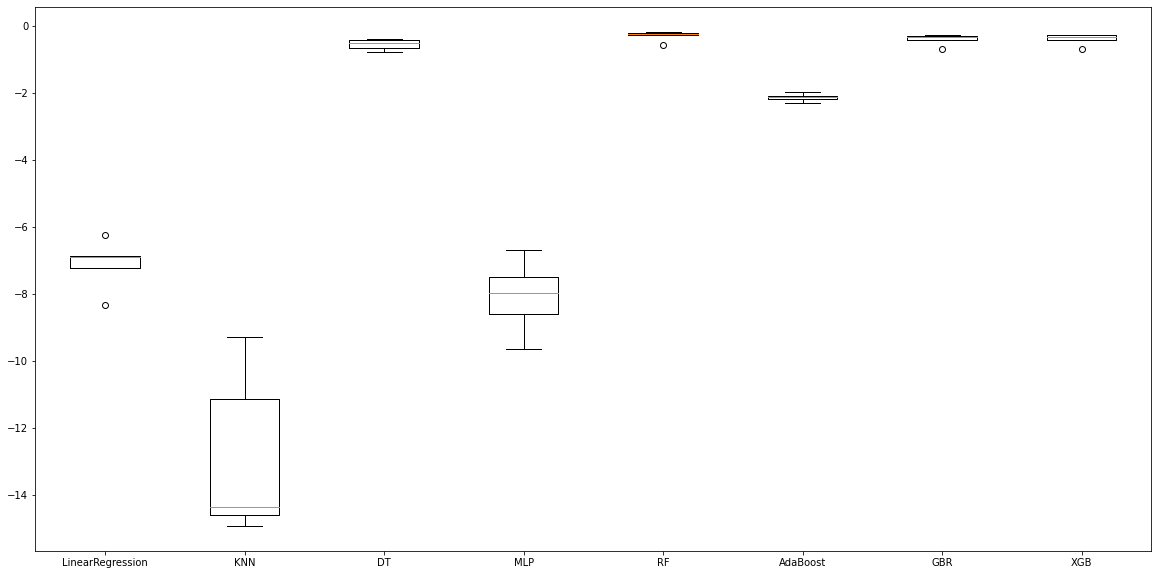

In [190]:
# 5 fold cv with mse error metric to choose the best model


## Try a bunch of models with cv
models = []
models.append(("LinearRegression",LinearRegression()))
models.append(("KNN", KNeighborsRegressor()))
models.append(("DT",DecisionTreeRegressor()))
models.append(("MLP", MLPRegressor(random_state=1, max_iter=500)))
models.append(("RF", RandomForestRegressor()))
models.append(("AdaBoost", AdaBoostRegressor()))
models.append(("GBR", GradientBoostingRegressor()))
models.append(("XGB", XGBRegressor()))

results = []
names = []
for name, model in models:
    # Cross validation for each model and append results
    kfold = KFold(n_splits = NFOLD, random_state = SEED, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=METRIC)
    results.append(cv_results)
    names.append(name)
    # print the mean mse and mse std for each model
    print("{0}: {1} ({2})".format(name, cv_results.mean(), cv_results.std()))

# Distribution performance
fig, ax = plt.subplots()
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# TODO: Random search NOT RUN
from sklearn.model_selection import RandomizedSearchCV

# random forest was the best model
# random search for hyperparameter tuning

# Create the search grid
rf_random = {'n_estimators': [100, 500, 1000],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [10, 70, 100],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}


# base model to tune
rf = RandomForestRegressor()
# Search of parameters, using 5 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_random, 
                               n_iter = 100, cv = NFOLD, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
random_search = rf_random.fit(X_train, y_train)
print("Best score {0} obtain with {1}".format(random_search.best_score_, random_search.best_params_))

In [213]:
# Did not have time to perform the Random search, chose the n estimators arbitrarily

model = RandomForestRegressor(n_estimators = 500)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [214]:
from math import sqrt
y_pred = model.predict(X_test)
print("MSE model: {0}".format(mean_squared_error(y_test, y_pred)))
print("RMSE model: {0}".format(sqrt(mean_squared_error(y_test, y_pred))))

MSE model: 0.35335204031184625
RMSE model: 0.5944342186582517


#Prediction of sales vs real values

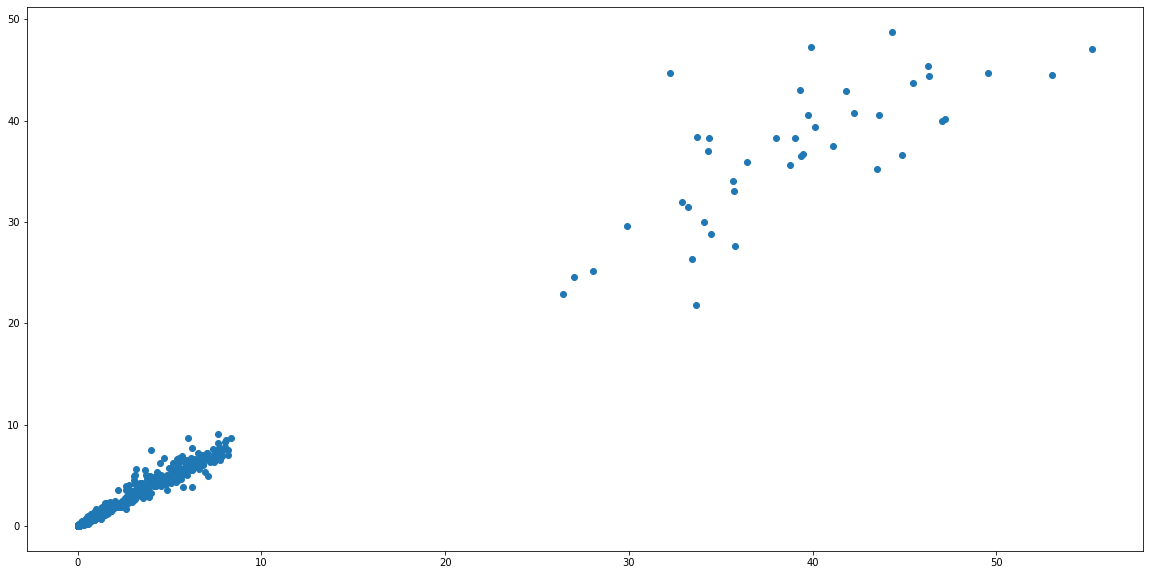

In [215]:
plt.scatter(y_pred,y_test)

#Plot the real sales vs predicted sales over time

In [216]:
real = df[df.index.isin(y_test.index)]
real['PredSales'] = y_pred*1000000

Text(0.5, 1.0, 'Real vs predicted sales')

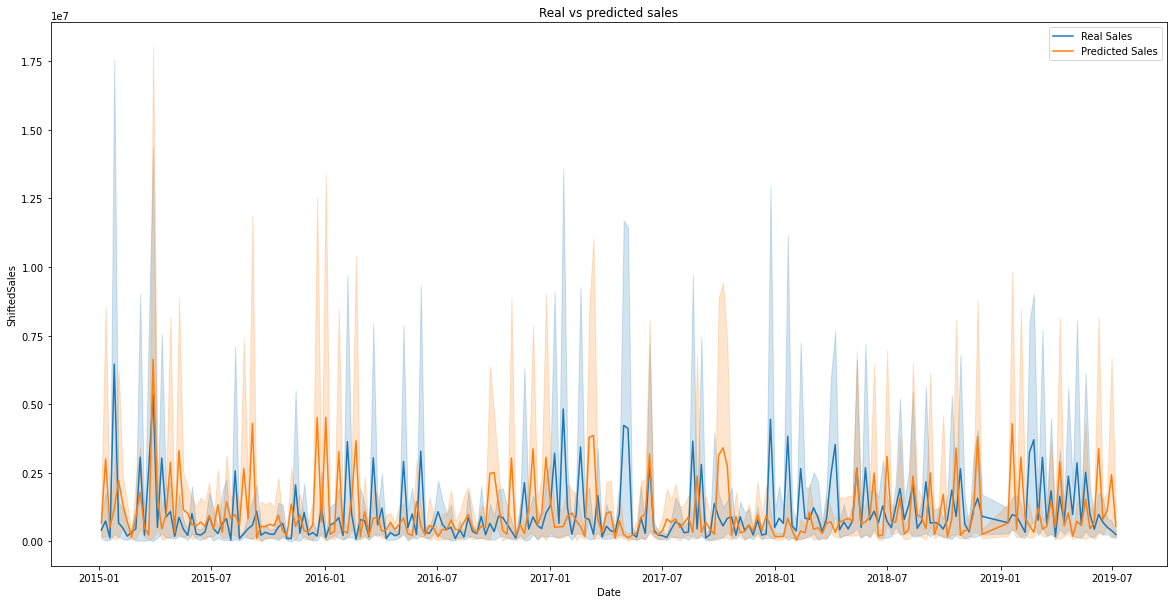

In [217]:
sns.lineplot(x='Date', y='ShiftedSales', data=real)
sns.lineplot(x='Date', y='PredSales', data=real)
plt.legend(labels=["Real Sales","Predicted Sales"])
plt.title('Real vs predicted sales')